In [1]:
import cv2
import numpy as np
import random
import sys 
from matplotlib import pyplot as plt


In [2]:
def showImg(img, title = str(round(random.random()*1000,0))):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyWindow(title)

In [3]:
def imageResizeByWidth(img, width=856):
    currRatio = img.shape[0]/img.shape[1]
    print('Shape: ', img.shape)
    height = int(width * currRatio)
    dim = (width, height)
    print('Resized shape: ', dim)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [20]:
fileNamePath = './data/tempEqualize2.jpg'
# fileNamePath = './data/temp2.jpg'

originImg = cv2.imread(fileNamePath)
showImg(originImg, "Origin image")

Getting Quoc Huy

In [17]:
qh_threshold = 10
minX = 70
minY = 50
qhDiameter = 180  # quoc huy co duong kinh la 14mm

qh = originImg[minY - qh_threshold:minY + qhDiameter + qh_threshold, minX -
               qh_threshold:minX + qhDiameter + qh_threshold]
showImg(qh, "Quoc Huy")

Getting CMND number

In [16]:
cardNu_threshold = 10
minX = 390
minY = 130
cardNuWidth = 360
cardNuHeight = 60

cardNu = originImg[minY - cardNu_threshold:minY + cardNuHeight + cardNu_threshold, minX -
               cardNu_threshold:minX + cardNuWidth + cardNu_threshold]
showImg(cardNu, "Card Number")

Loading Quoc Huy template

In [18]:
templateQh = cv2.imread('quoc_huy1.jpg')
templateQh = imageResizeByWidth(templateQh, 140)
templateQhGray = cv2.cvtColor(templateQh, cv2.COLOR_BGR2GRAY)
print("Shape: " ,templateQh.shape)
showImg(templateQh, 'Template QH')
# cv2.imwrite('qhTemplate.jpg', templateQh)

Shape:  (336, 330, 3)
Resized shape:  (140, 142)
Shape:  (142, 140, 3)


#### Quoc huy Shape

In [8]:
qhShape = cv2.imread('quochuy2_shape.jpg',0)
# qhShape = imageResizeByWidth(qhShape, 140)
print("Shape: ", qhShape.shape)

# showImg(qhShape, 'edge QH')

Shape:  (381, 659)


In [9]:

kernel = np.ones((1, 1), np.uint8)
qhShape = cv2.dilate(qhShape, kernel, iterations=1)
# showImg(qhShape, 'edge enhance QH')

qhShape = cv2.GaussianBlur(qhShape, (3, 3), cv2.BORDER_DEFAULT)
# showImg(qhShape, 'edge blur QH')


# Get edges
qhEdges = cv2.Canny(qhShape, 50, 120)
# showImg(qhEdges, 'edge QH')

In [10]:
img = np.zeros(shape=[512, 1000, 3], dtype=np.uint8)

In [11]:
contours, hierarchy = cv2.findContours(qhEdges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print ("Number of contours found = ", len(contours))

contours = sorted(contours, key=cv2.contourArea, reverse=True)

# img = qhShape.copy()
cv2.drawContours(img, contours, -1, (255,255,255), 2)

# for c in sorted_contours:
#     cv2.drawContours(orginal_image, [c], -1, (255,155,0), 3)
cv2.waitKey(0)
cv2.imshow('Contours by area', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

Number of contours found =  1


In [12]:
print(cv2.boundingRect(contours[0]))

temp = img[22:324+30,162:316+168]
temp = imageResizeByWidth(temp, 144)
temp = cv2.bitwise_not(temp)
showImg(temp)


(165, 26, 316, 324)
Shape:  (332, 322, 3)
Resized shape:  (144, 148)


In [15]:
cv2.imwrite('qhShape.jpg', temp)

True

### Shape of QH

In [73]:
qhShape = cv2.imread('qhShape.jpg',0)
# showImg(qhShape, "shape")
ret, thresh1 = cv2.threshold(qhShape, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
contours = sorted(contours, key=cv2.contourArea, reverse=True)

templateContour = contours[2]
# print(cv2.boundingRect(contours[0]))
# print(cv2.boundingRect(contours[1]))
# print(cv2.boundingRect(contours[2]))

# cv2.drawContours(qh, [templateContour], -1, (0,255,234), 2)
# showImg(qh,'res1')


3


#### get edge of origin qh

In [22]:
def getQHColor(img):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     showImg(hsv, "color")
    # cv.imshow("hsv", hsv)
    # define range of color in HSV

    ## Gen lower mask (0-5) and upper mask (175-180) of RED
    mask1 = cv2.inRange(hsv, (0,50,20), (35,255,255))
#     mask2 = cv2.inRange(hsv, (170,50,20), (180,255,255))

    ## Merge the mask and crop the red regions
    mask = cv2.bitwise_or(mask1, mask2 )

    res = cv2.bitwise_and(img , img, mask= mask)
    res = cv2.cvtColor(res, cv2.COLOR_HSV2BGR)
#     showImg(res,"getQH color")
    return res

In [75]:
def getEdgeImage(img):
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
#     showImg(img, 'edge enhance QH')
    img = cv2.GaussianBlur(img, (3,3), cv2.BORDER_DEFAULT)
    # showImg(img, 'edge blur QH')


    # Get edges
    edges = cv2.Canny(img, 50, 120)
    # showImg(qhEdges, 'edge QH')
    return edges

In [ ]:
qhColorImg = getQHColor(qh)
showImg(qhColorImg, "qhColorImg")

qh_gray = cv2.cvtColor(qhColorImg, cv2.COLOR_BGR2GRAY)
originQhThresh = getEdgeImage(qh_gray)

# ret, originQhThresh = cv2.threshold(qh_gray, 127, 255, 0)
showImg(originQhThresh, "originQhEdges")

# Extract contours from second target image
contours, hierarchy = cv2.findContours(originQhThresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

qhCopy = qh.copy()
cv2.drawContours(qhCopy, contours, -1, (0,255,0), 3)
showImg(qhCopy,'res')


In [83]:
# Size of QH is 
closest_contour = []
minMatch = sys.maxsize
print(minMatch)
for c in contours:
    area = cv2.contourArea(c)
#     print("area: ", area)
    if area <= 10:  # skip ellipses smaller then 10x10
        continue
    # Iterate through each contour in the target image and 
    # use cv2.matchShapes to compare contour shapes
    match = cv2.matchShapes(templateContour, c, cv2.CONTOURS_MATCH_I3, 0.0)
#     print(match)
    if match < minMatch:
        closest_contour = c
#     print(match)
    # If the match value is less than 0.15 we
#     if match < 0.2:
#         closest_contour = c

# print(cv2.boundingRect(closest_contour))
# print("closest_contour: ", closest_contour)
if closest_contour != []:
    qhCopy = qh.copy()
    cv2.drawContours(qhCopy, [closest_contour], -1, (50,155,30), 2)
    cv2.imshow('Output', qhCopy)
    cv2.waitKey()
    cv2.destroyAllWindows()
else:
    print("No match shape")

9223372036854775807


/home/hxtruong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


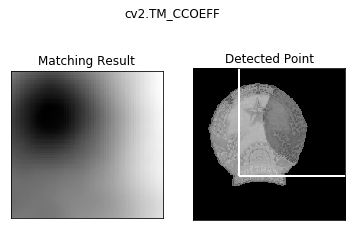

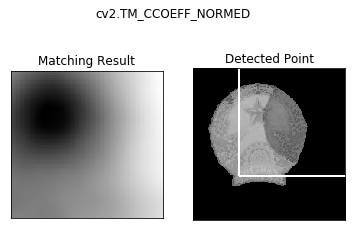

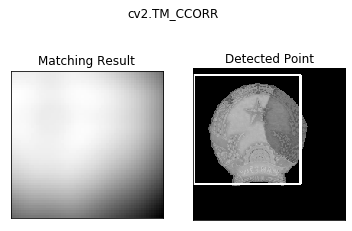

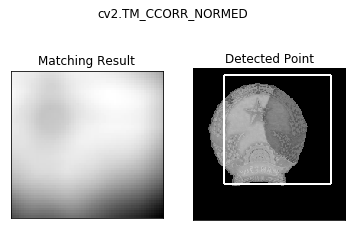

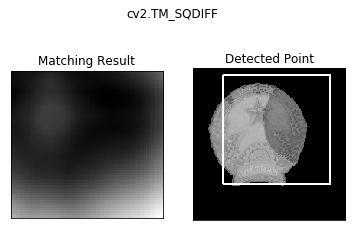

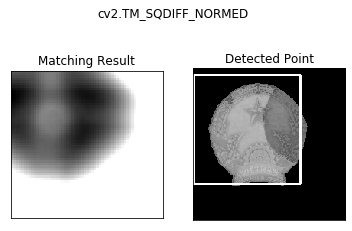

In [94]:

# img = cv2.imread('messi5.jpg',0)
img = qh_gray
img2 = img.copy()
# template = cv2.imread('template.jpg',0)
template = templateQhGray
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
#     print(res)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    
    plt.savefig('matchingQHTemplate'+str(meth)+ '.png')

    plt.show()

